### The performance function is:
   $$ g(X) = x_{1} + 2x_{2} + 2x_{3} + x_{4} - 5x_{5} -5x_{6}  $$
   
   with $ x_{1},...,x_{4} $ ~ lognormal(120,12), $x_{5}$ ~ lognormal(50,15), $x_{6}$ ~ lognormal(40,12)
   
   I think 120 is the mean and std before logarithm. But I still assume they are mean and sd for simplicity now
   

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import numpy as np
#import sympy as sp 
import matplotlib.pyplot as plt

### 1. Evaluate the function

In [4]:
# performance function
def func_1(x): 
    x = np.array(x, dtype='f')
    # expected number of random variables/columns
    nrv_e = 6
       
    if len(x.shape) == 1:
        nrv_p = x.shape[0]
        if nrv_p != nrv_e:
            raise ValueError('The number of random variables (x, columns) is expected to be ' + str(nrv_e) + ' but ' + str(nrv_p) + ' is provided!')
        else:
            g = x[0]+2*x[1]+2*x[2]+x[3]-5*x[4]-5*x[5] 
            
    elif len(x.shape) == 2:
        nrv_p = x.shape[1]
        if nrv_p != nrv_e:
            raise ValueError('The number of random variables (x, columns) is expected to be ' + str(nrv_e) + ' but ' + str(nrv_p) + ' is provided!')
        else:    
            g = x[:,0]+2*x[:,1]+2*x[:,2]+x[:,3]-5*x[:,4]-5*x[:,5]  
            
    else: 
        raise ValueError('Only available for ndims(n<3) arrays.')
 
    return g

In [5]:
#Input with a 1D array (1,6)
A = [1,2,3,4,5,6]
#get an error when the dims not match
B = [1,2,3]
# Input with 2D array (n,6)
C = [[0,0,0,0,0,0],[1,2,3,4,5,6],[1,1,1,1,1,1]]
# wrong dimension, 2D
D = [[0,0,0],[1,1,1],[2,2,2]]
# more than 2D
E = [[[0,0,0],[1,1,1],[2,2,2]], [[0,0,0],[1,1,1],[2,2,2]]]
# array input, 1D
F = np.array(A)
# array input, 2D
G = np.array(C)
# tuple input
H = (1,2,3,4,5,6)
#
I = [1,2,3,4,5,'y']

Inp = [A, B, C, D, E, F, G, H, I]

for idx,inp in enumerate(Inp):
    print('Input=' + str(idx+1))
    try:
        g = func_1(inp)
        print(g)
    except ValueError as error:
        print(error)
    print('--------------------')

Input=1
-40.0
--------------------
Input=2
The number of random variables (x, columns) is expected to be 6 but 3 is provided!
--------------------
Input=3
[  0. -40.  -4.]
--------------------
Input=4
The number of random variables (x, columns) is expected to be 6 but 3 is provided!
--------------------
Input=5
Only available for ndims(n<3) arrays.
--------------------
Input=6
-40.0
--------------------
Input=7
[  0. -40.  -4.]
--------------------
Input=8
-40.0
--------------------
Input=9
could not convert string to float: 'y'
--------------------


This is not desirable when python trace back, the function shows up. Do you have any idea to fix it?

The above solution is probably the desired one:
We can do the try catch on the server and can give back to the user only the error text. But when the performance function is downloaded after the challenge is over we want a complete error trace.

### 2. Find the range for plotting

In [6]:
def find_range(mean=None,std=None):
    
    if mean==None or std == None:
        raise ValueError('mean and std must be input')
    
    mean = np.array(mean, dtype='f')
    std = np.array(std, dtype='f')    
    
    if len(mean) != len(std):
        raise ValueError('dimension of mean and sd should be same')
    
    dim = len(mean)
    
    sup_range = np.zeros((2,dim))
    sup_range[0,:] = mean - 3*std
    sup_range[1,:] = mean + 3*std
    interval = 100
    # turn off the upper triangle
    
    diag = []
    off_diag = []
    for x_i in range(dim):
        for y_i in range(dim):  
            if x_i == y_i:
                x_grid = np.linspace(sup_range[0,x_i],
                                     sup_range[1,x_i],
                                     interval)
        
                Inputmatrix = np.array([[mean[i] for i in range(dim)] for j in range(interval)])
                Inputmatrix[:,x_i] = x_grid        
                               
                diag.append([np.amin(func_1(Inputmatrix)),np.amax(func_1(Inputmatrix))])
            
            if x_i > y_i:
                x_grid = np.linspace(sup_range[0,x_i],
                                     sup_range[1,x_i],
                                     interval)
                y_grid = np.linspace(sup_range[0,y_i],
                                     sup_range[1,y_i],
                                     interval)
                X,Y = np.meshgrid(x_grid,y_grid)
                
                Inputmatrix = np.array([[[mean[i] for i in range(dim)] for j in range(interval)] for k in range(interval)])   
                Z = np.zeros((interval,interval))
                
                for rows in range(Inputmatrix.shape[0]):
                    for col in range(Inputmatrix.shape[1]):
                        Inputmatrix[rows,col,x_i] = x_grid[rows]
                        Inputmatrix[rows,col,y_i] = y_grid[col]
                        Z[rows,col] = func_1(Inputmatrix[rows,col])
                        
                off_diag.append([np.amin(Z), np.amax(Z)])
                
    range_diag = [np.amin(np.array(diag)),np.amax(np.array(diag))]
    range_off_diag = [np.amin(np.array(off_diag)),np.amax(np.array(off_diag))]
    
    return range_diag, range_off_diag


Return a list including the y_max and y_min for diagonal 1D plot and off-diagonal contour plot

In [7]:
find_range([0,0,0,0,0,0],[1,1,1,1,1,1])

([-15.0, 15.0], [-30.0, 30.0])

### 3. Visualization by matrix plot

In [11]:
def visualize(mean=None,std=None):
    
    # get the range of y
    range_diag, range_off_diag = find_range(mean, std)
    
    mean = np.array(mean, dtype='f')
    std = np.array(std, dtype='f') 
    dim = len(mean)
    
    # amount of grid array 
    interval = 100
    
    fig,axes = plt.subplots(dim,dim,figsize=(dim+3,dim+3))
    sup_range = np.zeros((2,dim))
    sup_range[0,:] = mean - 3*std
    sup_range[1,:] = mean + 3*std

    # plotting
    for x_i in range(dim):
        for y_i in range(dim):
            # turn off the upper triangle
            if x_i < y_i:
                axes[x_i,y_i].axis('off')
            
            # diagonal    
            elif x_i == y_i:
                x_grid = np.linspace(sup_range[0,x_i],
                                     sup_range[1,x_i],
                                     interval)
        
                Inputmatrix = np.array([[mean[i] for i in range(dim)] for j in range(interval)])
                Inputmatrix[:,x_i] = x_grid        
        
                axes[x_i,x_i].plot(x_grid, func_1(Inputmatrix))
                axes[x_i,x_i].set_ylim([0.9*range_diag[0], 1.1*range_diag[1]])
                
                # left top corner
                if x_i == 0:
                    axes[0,0].set_xticks([])
                    axes[0,0].yaxis.tick_right()
                    axes[0,0].yaxis.set_label_position('right')
                    axes[0,0].set_ylabel(r'$G_{1}$',rotation=0)
                    
                # ???
                # any way to have a different y label showing x_1 ?
#                I tried twinx(), but seems like if I set the label position of original 
#                plot to right, the twin plot will change as well. This leads both x{1}
#                and G{1} are labelled at the right side, not labelled each side 

#                    ax_2 = axes[0,0].twinx()
#                    ax_2.set_ylabel(r'$x_{1}$',rotation=0)
#                    ax_2.set_xticks([])
#                    ax_2.set_yticks([])
                    
                # right bottom corner
                elif x_i == int(dim)-1:
                    axes[x_i,x_i].set_xlabel(r'$x_{}$'.format(int(dim)))
                    axes[x_i,x_i].yaxis.tick_right()
                    axes[x_i,x_i].yaxis.set_label_position('right')
                    axes[x_i,x_i].set_ylabel(r'$G_{}$'.format(int(x_i+1)),rotation=0)
                
                # the rest diagonal plot
                else:
                    axes[x_i,x_i].set_xticks([])
                    axes[x_i,x_i].yaxis.tick_right()
                    axes[x_i,x_i].yaxis.set_label_position('right')
                    axes[x_i,x_i].set_ylabel(r'$G_{}$'.format(int(x_i+1)),rotation=0)
                
                
                # set ticks smaller
                axes[x_i,x_i].tick_params(labelsize=6)
         
            # off diagonal
            else:
                x_grid = np.linspace(sup_range[0,x_i],
                                     sup_range[1,x_i],
                                     interval)
                y_grid = np.linspace(sup_range[0,y_i],
                                     sup_range[1,y_i],
                                     interval)
                X,Y = np.meshgrid(x_grid,y_grid)
                
                Inputmatrix = np.array([[[mean[i] for i in range(dim)] for j in range(interval)] for k in range(interval)])   
                Z = np.zeros((interval,interval))
                
                # creata a 3D array for input 
                for rows in range(Inputmatrix.shape[0]):
                    for col in range(Inputmatrix.shape[1]):
                        Inputmatrix[rows,col,x_i] = x_grid[rows]
                        Inputmatrix[rows,col,y_i] = y_grid[col]
                        Z[rows,col] = func_1(Inputmatrix[rows,col])
                        
                # for the colorbar later       
                color = axes[x_i,y_i].contourf(Y,X,Z,vmin=range_off_diag[0],\
                  vmax=range_off_diag[1],cmap=plt.cm.coolwarm)
                
                # left bottom corner
                if x_i == dim-1 and y_i == 0:
                    axes[x_i,y_i].set_xlabel(r'$x_{1}$')
                    axes[x_i,y_i].set_ylabel(r'$x_{}$'.format(int(dim)),rotation=0)
                
                # bottom edge x label
                elif x_i == dim-1:
                    if y_i != 0:
                        axes[x_i,y_i].set_yticks([])
                    axes[x_i,y_i].set_xlabel(r"$x_{}$".format(int(y_i+1)))
                    

                # left edge x label   
                elif y_i == 0:
                    axes[x_i,y_i].set_xticks([])
                    axes[x_i,y_i].set_ylabel(r"$x_{}$".format(int(x_i+1)),rotation=0)
                    
                else:
                    axes[x_i,y_i].set_yticks([])
                    axes[x_i,y_i].set_xticks([])
                
                axes[x_i,y_i].tick_params(labelsize=6)
                
    plt.suptitle('Visualization of Performance Function 1')
    
    # postition of colorbar
    cax = plt.axes([0.85,0.5,0.025,0.3])
    plt.colorbar(color,cax=cax)
#    fig.savefig('plot.png')
    return fig

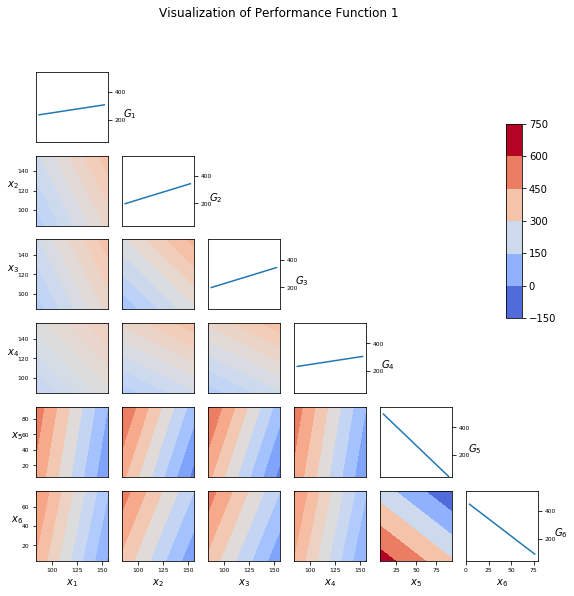

In [12]:
visualize([120,120,120,120,50,40],[12,12,12,12,15,12])

Random input

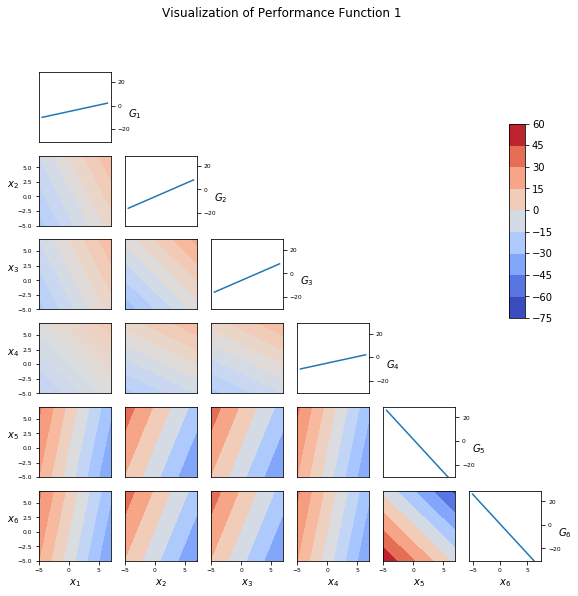

In [14]:
visualize([1,1,1,1,1,1],[2,2,2,2,2,2])

The main deficiencies in this figure are:
    
   1. The axis[0,0] only has G labelled, x_1 should be labelled on the other side as well, but I didn't find a good way to do it.
   2. The (cropped-like) plot you mentioned for example axes[4,4], still remains. This may due to I set the limit to exact the min or max value without any space left. I'm not sure how to optimize it. I considered times 0.9 to the min and 1.1 for the max, but this depends on if the value is positive or negative.
   3. The code is tedious and clumsy. A lot can be improved. But for now, I'm just focusing on making it work. Maybe you can optimize it later
   
   I will upload it to the share folder (the website you send to me perviously: repl.it) after you revise this file.
   I feel like jupter notebook looks better :)
   